## Imports

In [43]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data as data_utils

from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso
import sklearn

# Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu' # temporarily
# Fix random seeds for reproducibility
seed = 73
torch.manual_seed(seed)
np.random.seed(seed)

## VIB

### Methods

In [8]:
class VIB(nn.Module):
    """An implementation of the Variational Information Bottleneck Method."""

    def __init__(self, input_shape, output_shape, z_dim):
        # We'll use the same encoder as before but predict additional parameters
        #  for our distribution.
        super(VIB,self).__init__()
        
        
        self.input_shape    = input_shape
        self.output_shape   = output_shape
        self.z_shape        = z_dim #self.coef_dim*(self.coef_dim+3)/2
        
        self.nn_encoder = nn.Sequential(
                            nn.Linear(self.input_shape,512),
                            nn.GELU(),
                            nn.LayerNorm(512),               
                            nn.Linear(512,128),
                            nn.LayerNorm(128),
                            #nn.Linear(256,256),
                            nn.ReLU(),
                            #nn.LayerNorm(256),
                            #nn.Linear(1024,128),
                            #nn.GELU(),
                            #nn.LayerNorm(128),
                            )

        #self.nn_token  = nn.Linear(128, self.coef_dim) 
        #self.nn_prob = nn.Linear(512, self.z_dim)

        self.nn_weights  = nn.Linear(128, self.z_shape) 
        self.nn_std   = nn.Linear(128, self.z_shape)

        self.nn_decoder = nn.Sequential(nn.Linear(self.z_shape, 32),
                                        nn.GELU(),
                                        nn.LayerNorm(32),
                                        #nn.Linear(64, 16),
                                        #nn.GELU(),
                                        #nn.LayerNorm(16),
                                        nn.Linear(32, self.output_shape))
        
    def encoder(self, x):
        """
        x : (input_shape)
        """
        x = self.nn_encoder(x)
        #return self.nn_token(x), F.softplus(self.nn_prob(x)-5, beta=1)
        return self.nn_weights(x), F.softplus(self.nn_weights(x)-5, beta=1)

    def decoder(self, z):
        """
        z : (candidate_size)
        """ 
        return self.nn_decoder(z)

    
    
    def reparameterise(self, mean, std):
        """
        mean : (coef_dim)
        std  : (coef_dim)       
        """        
        # get epsilon from standard normal
        eps = torch.randn_like(std)
        return mean + std*eps

    
    def forward(self, x):
        """
        Forward pass 
        
        Parameters:
        -----------
        x : (input_shape)
        """
        mu, std = self.encoder(x)
        z = self.reparameterise(mu, std)
        return self.decoder(z), mu, std
    
def vib_loss(y_pred, y, mu, std, beta=0.01):
    """    
    y_pred : (output_shape)
    y      : (output_shape)    
    mu     : (z_dim)  
    std    : (z_dim)
    """   
    #CE = F.cross_entropy(y_pred, y, reduction='sum')
    CE = torch.sum((y-y_pred)**2)
    KL = 0.5 * torch.sum(mu.pow(2) + std.pow(2) - 2*std.log() - 1)
    return (beta*KL + CE) / y.size(0)

In [12]:
def train_vib(vib, train_loader, device,epochs=100,batch_size=50,test_dataset=None):
    
    # Optimiser
    optimiser = torch.optim.Adam(vib.parameters(), lr=learning_rate)
    #optimiser = torch.optim.SGD(vib.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimiser, gamma=decay_rate)

    
    # Send to GPU if available
    vib.to(device)
    
    # Training
    measures = defaultdict(list)
    start_time = time.time()

    # put Deep VIB into train mode 
    vib.train()  

    for epoch in range(epochs):
        epoch_start_time = time.time()  

        # exponential decay of learning rate every 2 epochs
        if epoch % 10 == 0 and epoch > 0:
            scheduler.step()    
            pass

        batch_loss = 0
        batch_accuracy = 0
        for _, (X,y) in enumerate(train_loader): 
            X = X.to(device)        
            y = y.float().to(device)

            vib.zero_grad()
            y_pred, mu, std = vib(X)
            loss = vib_loss(y_pred, y, mu, std)
            loss.backward()
            optimiser.step()  

            batch_loss += loss.item()*X.size(0) 
            batch_accuracy += torch.sum(torch.abs(y - y_pred)/y)/batch_size     
            
        if test_dataset is not None:
            X, y = test_dataset.tensors
            y_pred, _,_ = vib(torch.tensor(X,dtype=torch.float).to(device))
            y_pred = y_pred.cpu().detach().numpy()
            test_accuray = np.abs(y-y_pred)/y
            #print(test_accuray.max())
            test_accuray = test_accuray.mean(axis=0)
            #test_accuray = test_accuray.mean()
            #print(test_accuray)
        else:
            test_accuray = -1.0
        # Save losses per epoch
        measures['total_loss'].append(batch_loss / len(train_loader.dataset))        
        # Save accuracy per epoch
        measures['accuracy'].append(batch_accuracy.cpu().detach() / len(train_loader.dataset))            
        if (epoch + 1) % 100 == 0 and epoch > 0:
            print("Epoch: {}/{}...".format(epoch+1, epochs),
                  "Loss: {:.4f}...".format(measures['total_loss'][-1]),
                  "Accuracy: {:.4f}...".format(measures['accuracy'][-1]),
                  "Test Om: {:.3f} sig: {:.3f}".format(test_accuray[0],test_accuray[1]))
                  #"Time Taken: {:,.4f} seconds".format(time.time()-epoch_start_time))
            
    #torch.save(vib.state_dict(),"./models/model_LH_DMO_J_{}_L_{}_sigma_{}_power_{}.npy".format(J,L,sigma,integral_powers))
    return np.mean(measures['total_loss'][-10:]), np.mean(measures['accuracy'][-10:])

### Data load

In [31]:
fparam = "/mnt/ceph/users/fvillaescusa/Nbody_systematics/data/maps/maps_Gadget/params_Gadget.txt"
gparams = np.loadtxt(fparam)
gparams = gparams[:,:2] ## only Om and Sig8
fparam = "/mnt/ceph/users/fvillaescusa/Nbody_systematics/data/maps/maps_Ramses/params_Ramses.txt"
rparams = np.loadtxt(fparam)
rparams = rparams[:,:2] ## only Om and Sig8
params  = np.r_[gparams, rparams]

coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nGadget_for_vib_total.npy")
gcoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    gcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nRamses_for_vib_total.npy")
rcoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    rcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.r_[gcoef_avg, rcoef_avg]
print(coef.shape, params.shape)

(2000, 513) (2000, 2)


/tmp/ipykernel_3995636/94548671.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  gcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
/tmp/ipykernel_3995636/94548671.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  rcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)


## VIB for Gadget

### Normalizations & Dataset for training

In [36]:
batch_size = 100
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
y = torch.tensor(gparams,dtype=torch.float)
X = torch.tensor(gcoef_avg,dtype=torch.float)
dataset      = data_utils.TensorDataset(X, y)
dataset_size = len(dataset)
indices      = list(range(dataset_size))
split        = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader  = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
test_dataset      = data_utils.TensorDataset(X[val_indices], y[val_indices])

### Training VIB

In [37]:
# Hyperparameters
beta   = 1e-3
input_shape  = coef.shape[1]
output_shape = 2
learning_rate = 1e-3
decay_rate = 0.97
z_dim = 50
epochs = 3000


vib = VIB(input_shape, output_shape,z_dim)
total_loss, accuracy = train_vib(vib, train_loader, device, epochs,batch_size,test_dataset)
#del vib

/tmp/ipykernel_3995636/2107878760.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred, _,_ = vib(torch.tensor(X,dtype=torch.float).to(device))


Epoch: 100/3000... Loss: 1.6163... Accuracy: 0.0030... Test Om: 0.257 sig: 0.113
Epoch: 200/3000... Loss: 1.6142... Accuracy: 0.0024... Test Om: 0.302 sig: 0.104
Epoch: 300/3000... Loss: 1.6119... Accuracy: 0.0021... Test Om: 0.191 sig: 0.091
Epoch: 400/3000... Loss: 1.6104... Accuracy: 0.0018... Test Om: 0.158 sig: 0.092
Epoch: 500/3000... Loss: 1.6100... Accuracy: 0.0018... Test Om: 0.158 sig: 0.086
Epoch: 600/3000... Loss: 1.6096... Accuracy: 0.0018... Test Om: 0.157 sig: 0.081
Epoch: 700/3000... Loss: 1.6091... Accuracy: 0.0016... Test Om: 0.153 sig: 0.079
Epoch: 800/3000... Loss: 1.6089... Accuracy: 0.0016... Test Om: 0.152 sig: 0.079
Epoch: 900/3000... Loss: 1.6087... Accuracy: 0.0016... Test Om: 0.154 sig: 0.075
Epoch: 1000/3000... Loss: 1.6085... Accuracy: 0.0015... Test Om: 0.160 sig: 0.074
Epoch: 1100/3000... Loss: 1.6083... Accuracy: 0.0015... Test Om: 0.142 sig: 0.073
Epoch: 1200/3000... Loss: 1.6081... Accuracy: 0.0014... Test Om: 0.155 sig: 0.071
Epoch: 1300/3000... Loss:

tensor(0.1445)
tensor(0.0708)


/tmp/ipykernel_3995636/1209562079.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred, mu, std = vib(torch.tensor(X,dtype=torch.float).to(device))


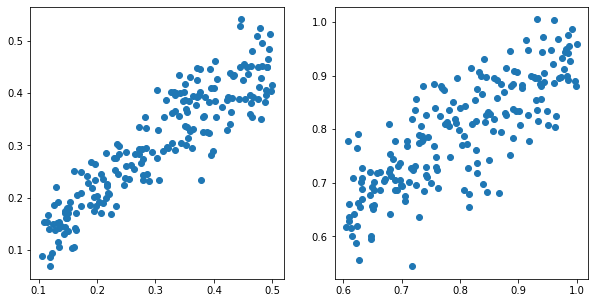

In [38]:
vib.eval()
X, y =test_dataset.tensors
y_pred, mu, std = vib(torch.tensor(X,dtype=torch.float).to(device))
y_pred = y_pred.cpu().detach().numpy()

rel1 = np.abs(y[:,0]-y_pred[:,0])/y[:,0]
rel2 = np.abs(y[:,1]-y_pred[:,1])/y[:,1]
print(rel1.mean())
print(rel2.mean())
fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
plt.scatter(y[:,0],y_pred[:,0])
fig.add_subplot(1,2,2)
plt.scatter(y[:,1],y_pred[:,1])

## VIB for Both

### Normalizations & Dataset for training

In [39]:
batch_size = 100
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
y = torch.tensor(params,dtype=torch.float)
X = torch.tensor(coef,dtype=torch.float)
dataset      = data_utils.TensorDataset(X, y)
dataset_size = len(dataset)
indices      = list(range(dataset_size))
split        = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader  = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
test_dataset      = data_utils.TensorDataset(X[val_indices], y[val_indices])

### Training VIB

In [40]:
# Hyperparameters
beta   = 1e-3
input_shape  = coef.shape[1]
output_shape = 2
learning_rate = 1e-3
decay_rate = 0.97
z_dim = 50
epochs = 3000


vib = VIB(input_shape, output_shape,z_dim)
total_loss, accuracy = train_vib(vib, train_loader, device, epochs,batch_size,test_dataset)
#del vib

/tmp/ipykernel_3995636/2107878760.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred, _,_ = vib(torch.tensor(X,dtype=torch.float).to(device))


Epoch: 100/3000... Loss: 1.6140... Accuracy: 0.0024... Test Om: 0.228 sig: 0.098
Epoch: 200/3000... Loss: 1.6119... Accuracy: 0.0020... Test Om: 0.230 sig: 0.117
Epoch: 300/3000... Loss: 1.6108... Accuracy: 0.0019... Test Om: 0.155 sig: 0.081
Epoch: 400/3000... Loss: 1.6101... Accuracy: 0.0017... Test Om: 0.138 sig: 0.077
Epoch: 500/3000... Loss: 1.6087... Accuracy: 0.0015... Test Om: 0.143 sig: 0.080
Epoch: 600/3000... Loss: 1.6083... Accuracy: 0.0015... Test Om: 0.127 sig: 0.066
Epoch: 700/3000... Loss: 1.6076... Accuracy: 0.0013... Test Om: 0.123 sig: 0.062
Epoch: 800/3000... Loss: 1.6072... Accuracy: 0.0013... Test Om: 0.133 sig: 0.059
Epoch: 900/3000... Loss: 1.6070... Accuracy: 0.0013... Test Om: 0.111 sig: 0.067
Epoch: 1000/3000... Loss: 1.6067... Accuracy: 0.0012... Test Om: 0.111 sig: 0.059
Epoch: 1100/3000... Loss: 1.6065... Accuracy: 0.0011... Test Om: 0.118 sig: 0.056
Epoch: 1200/3000... Loss: 1.6063... Accuracy: 0.0011... Test Om: 0.109 sig: 0.054
Epoch: 1300/3000... Loss:

tensor(0.1075) 0.892071694376535
tensor(0.0513) 0.7705467460818147


/tmp/ipykernel_3995636/2405665974.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred, mu, std = vib(torch.tensor(X,dtype=torch.float).to(device))


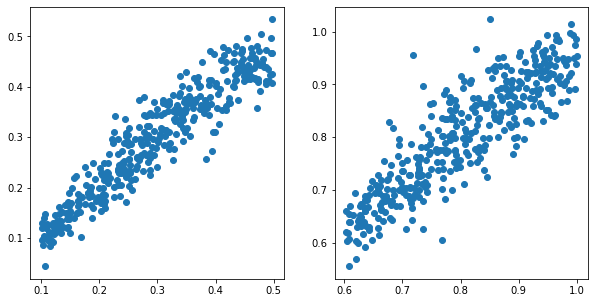

In [44]:
vib.eval()
X, y =test_dataset.tensors
y_pred, mu, std = vib(torch.tensor(X,dtype=torch.float).to(device))
y_pred = y_pred.cpu().detach().numpy()

rel1 = np.abs(y[:,0]-y_pred[:,0])/y[:,0]
rel2 = np.abs(y[:,1]-y_pred[:,1])/y[:,1]
print(rel1.mean(),sklearn.metrics.r2_score(y[:,0],y_pred[:,0]))
print(rel2.mean(),sklearn.metrics.r2_score(y[:,1],y_pred[:,1]))
fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
plt.scatter(y[:,0],y_pred[:,0])
fig.add_subplot(1,2,2)
plt.scatter(y[:,1],y_pred[:,1])

## Without normalization

### Data load

In [27]:
fparam = "/mnt/ceph/users/fvillaescusa/Nbody_systematics/data/maps/maps_Gadget/params_Gadget.txt"
gparams = np.loadtxt(fparam)
gparams = gparams[:,:2] ## only Om and Sig8
fparam = "/mnt/ceph/users/fvillaescusa/Nbody_systematics/data/maps/maps_Ramses/params_Ramses.txt"
rparams = np.loadtxt(fparam)
rparams = rparams[:,:2] ## only Om and Sig8
params  = np.r_[gparams, rparams]

coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_Gadget_for_vib_total.npy")
gcoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    gcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_Ramses_for_vib_total.npy")
rcoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    rcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.r_[gcoef_avg, rcoef_avg]
print(coef.shape, params.shape)

(2000, 513) (2000, 2)


/tmp/ipykernel_3995636/1580927091.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  gcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
/tmp/ipykernel_3995636/1580927091.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  rcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)


### Normalizations & Dataset for training

In [28]:
batch_size = 100
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
y = torch.tensor(params,dtype=torch.float)
X = torch.tensor(coef,dtype=torch.float)
dataset      = data_utils.TensorDataset(X, y)
dataset_size = len(dataset)
indices      = list(range(dataset_size))
split        = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader  = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
test_dataset      = data_utils.TensorDataset(X[val_indices], y[val_indices])

### Training VIB

In [29]:
# Hyperparameters
beta   = 1e-3
input_shape  = coef.shape[1]
output_shape = 2
learning_rate = 1e-3
decay_rate = 0.97
z_dim = 50
epochs = 3000


vib = VIB(input_shape, output_shape,z_dim)
total_loss, accuracy = train_vib(vib, train_loader, device, epochs,batch_size,test_dataset)
#del vib

/tmp/ipykernel_3995636/2107878760.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred, _,_ = vib(torch.tensor(X,dtype=torch.float).to(device))


Epoch: 100/3000... Loss: 1.6258... Accuracy: 0.0047... Test Om: 0.486 sig: 0.122
Epoch: 200/3000... Loss: 1.6256... Accuracy: 0.0046... Test Om: 0.441 sig: 0.122
Epoch: 300/3000... Loss: 1.6255... Accuracy: 0.0046... Test Om: 0.465 sig: 0.123
Epoch: 400/3000... Loss: 1.6253... Accuracy: 0.0046... Test Om: 0.449 sig: 0.121
Epoch: 500/3000... Loss: 1.6253... Accuracy: 0.0046... Test Om: 0.445 sig: 0.123
Epoch: 600/3000... Loss: 1.6253... Accuracy: 0.0046... Test Om: 0.449 sig: 0.122
Epoch: 700/3000... Loss: 1.6253... Accuracy: 0.0046... Test Om: 0.452 sig: 0.122
Epoch: 800/3000... Loss: 1.6253... Accuracy: 0.0046... Test Om: 0.455 sig: 0.122
Epoch: 900/3000... Loss: 1.6253... Accuracy: 0.0046... Test Om: 0.455 sig: 0.122
Epoch: 1000/3000... Loss: 1.6253... Accuracy: 0.0046... Test Om: 0.452 sig: 0.122
Epoch: 1100/3000... Loss: 1.6253... Accuracy: 0.0046... Test Om: 0.453 sig: 0.122
Epoch: 1200/3000... Loss: 1.6253... Accuracy: 0.0046... Test Om: 0.453 sig: 0.122
Epoch: 1300/3000... Loss:

tensor(0.4522)
tensor(0.1223)


/tmp/ipykernel_3995636/1209562079.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred, mu, std = vib(torch.tensor(X,dtype=torch.float).to(device))


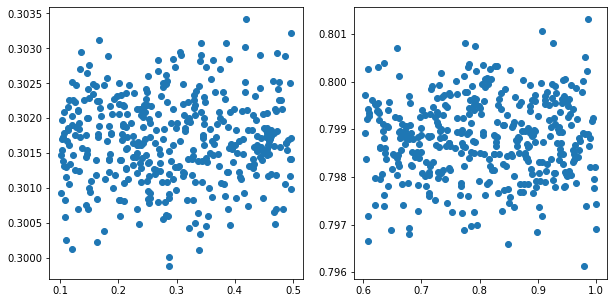

In [30]:
vib.eval()
X, y =test_dataset.tensors
y_pred, mu, std = vib(torch.tensor(X,dtype=torch.float).to(device))
y_pred = y_pred.cpu().detach().numpy()

rel1 = np.abs(y[:,0]-y_pred[:,0])/y[:,0]
rel2 = np.abs(y[:,1]-y_pred[:,1])/y[:,1]
print(rel1.mean())
print(rel2.mean())
fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
plt.scatter(y[:,0],y_pred[:,0])
fig.add_subplot(1,2,2)
plt.scatter(y[:,1],y_pred[:,1])

0.23162059822659814
0.1143907569643269


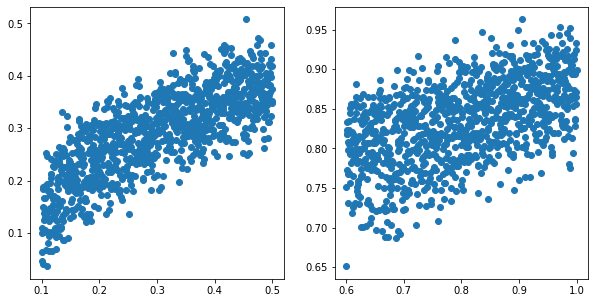

In [18]:
vib.eval()
X=coef
y = params
y_pred, mu, std = vib(torch.tensor(X,dtype=torch.float).to(device))
y_pred = y_pred.cpu().detach().numpy()

rel1 = np.abs(y[:,0]-y_pred[:,0])/y[:,0]
rel2 = np.abs(y[:,1]-y_pred[:,1])/y[:,1]
print(rel1.mean())
print(rel2.mean())
fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
plt.scatter(y[:,0],y_pred[:,0])
fig.add_subplot(1,2,2)
plt.scatter(y[:,1],y_pred[:,1])